# NBA Players Statistics Brochure

The goal of this project is to create a PDF brochure with career statistics and earnings for a given NBA player. 

The brochure contains the following information: 

- name,
- position,
- nationality,
- when was drafted ,
- total years in the NBA,
- logo of the current team (last team played for if retired),
- average points per year,
- average assists per year,
- average rebounds per year ,
- earnings per year.

The statistics is obtained from Spotrac.com website. Only data after 2011 is available. The logos were downloaded from ESPN.com.


## Description

The project is done in two steps. First we download all the necessary data, and then create the brochure using that data.

### Collecting the data

The data is obtained from Spotrac.com using  **BeautifulSoup** Python library.

The following function is used to collect the data and store it in a CSV file.

Libraries used:

In [1]:
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup

Before moving on to the function itself, we need to define just one helper function that cleans out the data in case a players has more than one source of income for a given year.

In [2]:
def clean_salary_entries(salary):
    """ Sums up all the income because sometimes players have retained earnings."""
    sal = salary.replace(',', '').split('$')
    sal = [int(s) for s in sal if s != '']
    return '$' + f"{sum(sal):,}"

The function accepts player's name as a parameter. It uses that name to search for that player's page using Spotrac internal search engine. If only one player with that name exists, we go directly to the page. If there are several players with that name, we choose the first one, since that is usually the most famous player, and we assume he is the one we are looking for.   

In [ ]:
def download_stats(player):
    """ Collects stats and salary information for a player from Spotrac website as
    of 2024. Only stats after 2011 are available."""    
    # Step 1. Get players ID on Spotrac.
    player_name = player.lower().replace(' ', '+')

    page = urllib.request.urlopen(f"https://www.spotrac.com/search?q={player_name}")
    soup = BeautifulSoup(page, "html.parser")
    rows = soup.find_all("a", class_="list-group-item")

    players_page = ''
    if len(rows) > 0:
        id = rows[0]['href'].split('/')[-1]
        players_page = f"https://www.spotrac.com/nba/player/statistics/_/id/{id}"
    else:
        players_page = f"https://www.spotrac.com/search?q={player_name}"

First, we get all the earnings of the player since 2011 per year. Spotrac has the salary information before year 2011 also, but not the statistcs before that year. In order for the data to be consistent with subsequent info, we delete all the earnings information before 2011.

In [ ]:
    # Step 2. Get salaries.
    page = urllib.request.urlopen(players_page)

    soup = BeautifulSoup(page, "html.parser")
    rows = soup.find_all("tr", class_="")
    earnings = []
    header_met = False
    for row in rows:
        r = row.text.replace(' ', '').split()
        if r == ['Year', 'Team(s)', 'Age', 'Base', 'Signing', 'Incentives', 'CashTotal', 'CashCumulative']:
            header_met = True
        if r == ['Years', 'Team', 'Base', 'Signing', 'Incentives', 'CashCumulative']:
            header_met = False
        if header_met:
            earnings.append(r)

    columns = ['Year', 'Age', 'BaseSalary', 'CashTotal', 'CashCumulative']
    new_columns = ['Year', 'Age', 'BaseSalary']
    salaries = pd.DataFrame(earnings[1:], columns=columns)
    salaries = salaries.drop(salaries[salaries['Year'].astype(int) < 2011].index)
    salaries = salaries[new_columns]
    salaries = salaries.reset_index(drop=True)

    salaries['BaseSalary'] = salaries['BaseSalary'].apply(clean_salary_entries)

Next, we collect the playing statistics: average points, assists and rebounds per game for each year. Once we have it, we concatenate this information with the earnings and save it to a CSV file. Pandas library is used to perform all of that.

We also store the name of the player's current team and if he is an active player in separate variables. We will need that later.


In [ ]:
    # Step 3. Get stats.
    rows = soup.find_all("tr", class_="")
    statistics = []
    header_met = False
    for row in rows:
        r = row.text.replace(' ', '').split()
        if r == ['Year', 'Team', 'GP', 'GS', 'Min/Gm', 'Pt/Gm', 'Reb/Gm', 'Ast/Gm', 'Stl/Gm', 'Blk/Gm', 'FG%', '3PT%', 'FT%']:
            header_met = True
        if header_met: # Spotrac doesn't provide 'games started' info for 2011 and 2012.
            if r[0] in ['2011', '2012']:
                r.insert(3, 'n/a')
            statistics.append(r)

    statistics = pd.DataFrame(statistics[1:], columns=statistics[0])

    current_team_abrv = statistics['Team'].values.copy()[0]
    is_active = True if statistics['Year'].values[0] == '2024' else False

    statistics = statistics.drop(statistics[statistics['Year'].astype(int) == 2024].index)
    statistics = statistics.iloc[::-1].reset_index(drop=True)

    # Join stats and salaries into one table.
    statistics['Age'] = salaries['Age'].values
    statistics['BaseSalary'] = salaries['BaseSalary'].values
    final_columns = ['Year', 'Age', 'Team', 'GP', 'GS', 'Min/Gm', 'Pt/Gm', 'Reb/Gm', 'Ast/Gm', 'Stl/Gm', 'Blk/Gm', 'FG%', '3PT%', 'FT%', 'BaseSalary']
    statistics = statistics[final_columns]

    # Save stats to file.
    csv_file_name = f"{player.replace(' ', '_')}.csv"
    statistics.to_csv(f"out_data/{csv_file_name}")

Finally, we collect some important bio information and store it in a .txt file.

In [ ]:
    # Step 4. Get players info.
    rows = soup.find_all("div", class_="row m-0 mt-0 pb-3")
    information = []
    for row in rows:
        r = row.text.split('/n')[0].split('\n')
        information.append(r)
    information = [info for info in information[0] if info != '']

    players_info = ['Team: ' + information[0], information[2], information[3], information[5], current_team_abrv, is_active]

    # Save to file.
    file_name = f"{player.replace(' ', '_')}.txt"
    with open(f"out_data/{file_name}", "w") as output:
        for row in players_info:
            output.write(str(row) + '\n')  

All the information is saved to /out_data folder. Player's name is used as the CSV filename. 

### Creating the Brochure

The brochure is created in PDF format using **fpdf** library.

All the statistical information is taken from the CSV file that was previously saved.

The PDF file created is stored in the root directory.

Note: Some temporary file are being created while running this program. They are deleted at the end.

In [ ]:
import pandas as pd
from fpdf import FPDF
from fpdf.enums import XPos, YPos
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os


# Parameters of the brochure
text_color = (105,105,105)
graph_text_color = '#808080'
stats_graph_color = '#658585'
earnings_graph_color = '#677e84'
linewidth = 1.4

def create_img(model, fig):
    fig.savefig('tmp.png')
    model.image('tmp.png', x=5, h=20)
    os.remove('tmp.png')

def set_graph_parameters(ax, title_str):
    ax.spines['bottom'].set_color(graph_text_color)
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color(graph_text_color)
    ax.tick_params(axis='x', colors=graph_text_color)
    ax.tick_params(axis='y', colors=graph_text_color)
    plt.title(title_str, x=0.9, y=0.9, fontsize=8, font='Noto Sans', color='#808080')

def print_stats_graph(x, y, model, title_str):
    fig, ax = plt.subplots(figsize=(11, 2))
    plt.plot(x, y, color=stats_graph_color, linewidth=linewidth)
    set_graph_parameters(ax, title_str)
    create_img(model, fig)

def print_line(model, y_space, x_space, text, size, style):
    model.set_font('helvetica', style=style, size=size)
    model.set_text_color(text_color)
    model.ln(y_space)
    model.cell(x_space)
    model.cell(text=text, new_y=YPos.NEXT)    

def get_info(player):
    filename = f"out_data/{player.replace(' ', '_')}.txt"
    with open(filename) as f:
        lines = f.read().splitlines()
    return lines

def create_pdf(player):
    class PDF(FPDF):
        """ Creating a footer for the brochure. """
        def footer(self):
            self.set_y(-15.5)
            self.set_x(-90)
            self.set_font('Helvetica', 'I', 5)
            self.set_text_color(200, 200, 200)
            self.cell(0, 10, text="Data courtesy of Spotrac.com. Team logo downloaded from ESPN.com. Created by apnoorex")
            self.cell(10)
            self.image('in_data/qrcode/qr_code.png', x=113, y=203.8, h=5)

    # Import data
    player_info = get_info(player)

    filename = f"out_data/{player.replace(' ', '_')}.csv"
    stats = pd.read_csv(filename)

    # Variables
    current_team = player_info[0].split(',')[0].split(':')[-1]
    first_year = stats['Year'][0]
    last_year = stats['Year'].iloc[-1]
    earnings = [int(s.replace('$', '').replace(',', '')) for s in list(stats['BaseSalary'])]
    points = [float(s) for s in list(stats['Pt/Gm'])]
    assists = [float(s) for s in list(stats['Ast/Gm'])]
    rebounds = [float(s) for s in list(stats['Reb/Gm'])]
    years = [str(s) for s in list(stats['Year'])]

    # Create a blank PDF page
    pdf = PDF('P', 'mm', format=(124, 215))
    pdf.add_page()

    # Add logo
    pdf.image(f"in_data/logos/{player_info[-2]}.png", x=12, y=12, h=40)

    # First name
    print_line(pdf, 6, 52, player.split()[0], 16, 'B')
    # Last name
    print_line(pdf, 2, 52, player.split()[1], 22, 'B')
    # Position
    print_line(pdf, 6, 52, 'Position:' + str(player_info[0].split(',')[-1]), 8, '')
    # Country
    print_line(pdf, 1.5, 52, player_info[2], 8, '')
    # Experience
    print_line(pdf, 1.5, 52, player_info[1], 8, '')
    # Draft info
    print_line(pdf, 1.5, 52, player_info[3], 8, '')

    # Information block is different for retired and active players
    if player_info[-1] == 'True':
        about_1 = f"{player.split()[0]} has earned ${sum(earnings):,} since {first_year} not including endorsement contracts."
        about_2 = f"He is currently playing for the{current_team}."
    else:
        about_1 = f"{player.split()[0]} earned ${sum(earnings):,} since {first_year} not including endorsement contracts."
        about_2 = f"He retired in {last_year}."

    # Summary line
    print_line(pdf, 11, 0.001, about_1, 8, '')
    # Current status line
    print_line(pdf, 3, 0.001, about_2, 8, '')

    # Career statistics statement
    print_line(pdf, 7, 0.01, 'Career statistics:', 8, '')
    pdf.ln(5)

    # Points per game
    print_stats_graph(years, assists, pdf, 'Points per game')
    # Assists per game
    print_stats_graph(years, points, pdf, 'Assists per game')
    # Rebounds per game
    print_stats_graph(years, rebounds, pdf, 'Rebounds per game')

    # Earnings per year statement
    print_line(pdf, 7, 0.01, 'Earnings per year:', 8, '')
    pdf.ln(5)

    # Earnings graph
    fig, ax = plt.subplots(figsize=(11, 2))
    plt.plot(years, earnings, color=earnings_graph_color, linewidth=1.5)
    set_graph_parameters(ax, '')
    ax = plt.gca()
    mkfunc = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.1fK' % (x * 1e-3) if x >= 1e3 else '%1.1f' % x
    mkformatter = FuncFormatter(mkfunc)
    ax.yaxis.set_major_formatter(mkformatter)
    fig.savefig('tmpg.png')
    pdf.image('tmpg.png', x=5, h=20)
    os.remove('tmpg.png')

    # Save file
    pdf.output(f"NBA_{player.replace(' ', '_')}.pdf")

### Top level code

The following top level code creates a PDF brochure for every player whose name is provided by the user.

Note: The program has the following limitations: 1. If a player retired because of an injury but before his contract expired (was getting paid, but didn't play), the result might be unexpected. Example: Chris Bosh. 2. If a player has incentives in addition to the salary, the result might be corrupted also. Example: Doug McDermott.

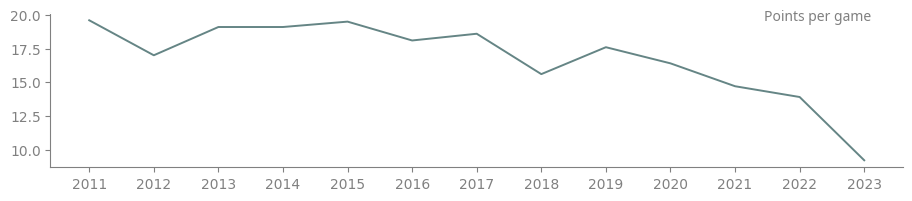

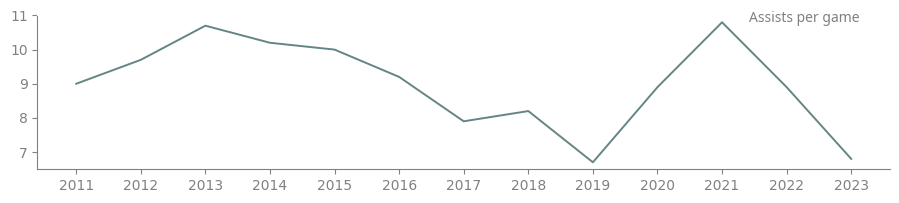

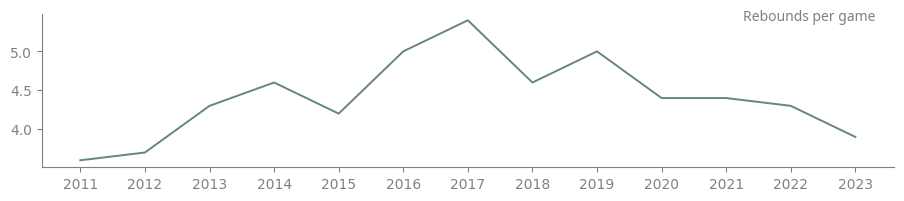

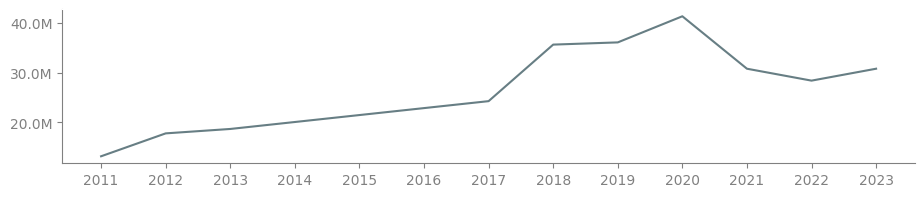

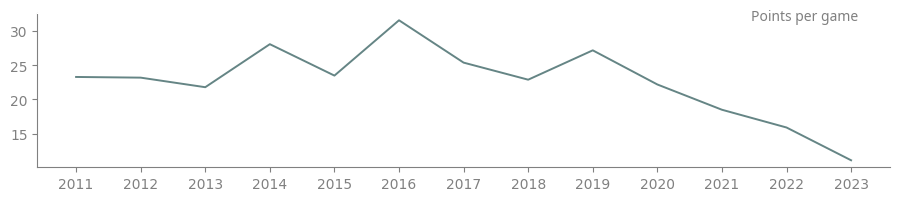

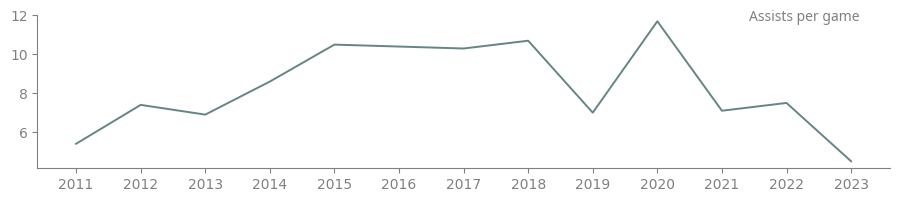

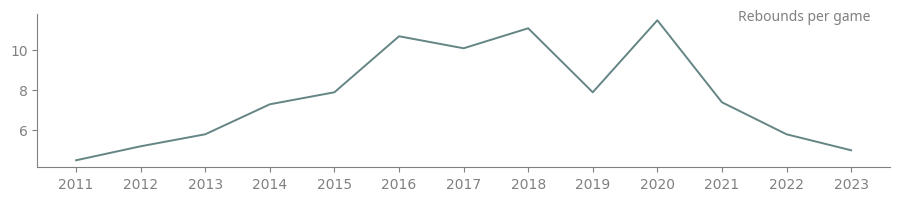

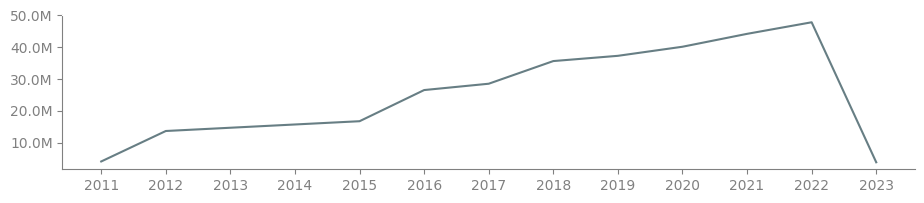

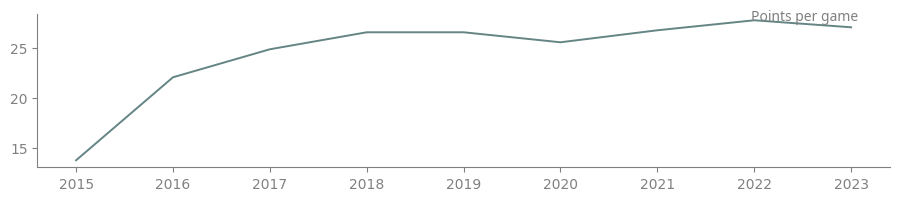

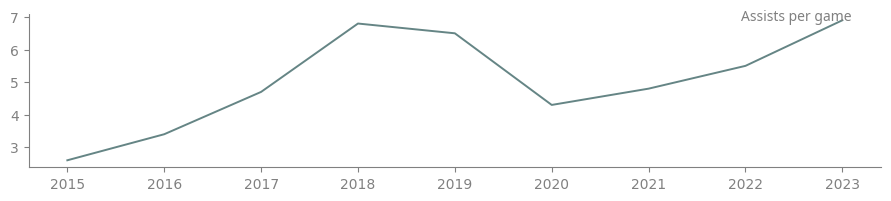

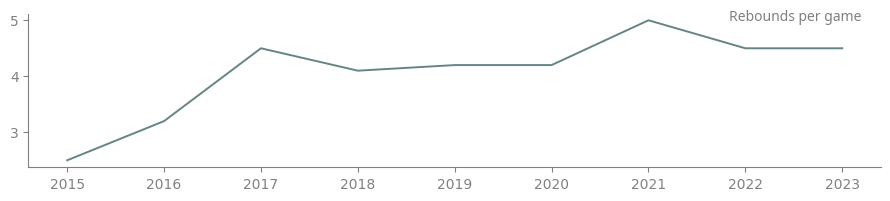

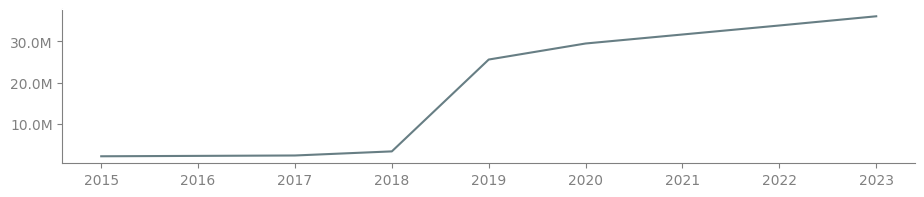

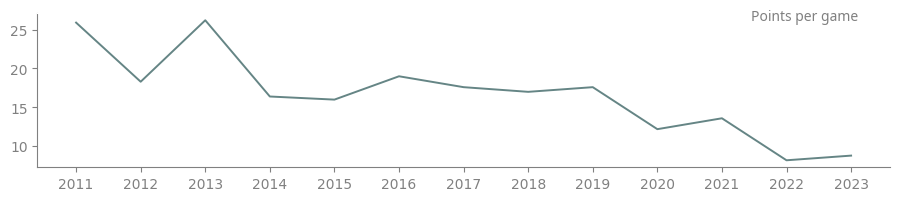

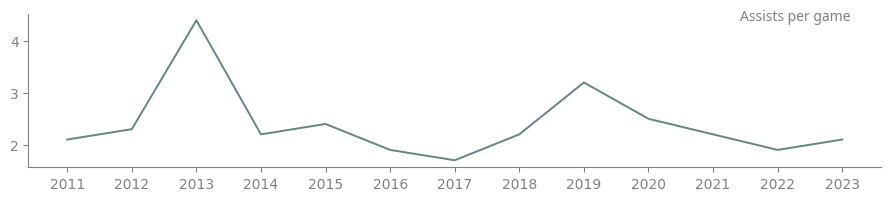

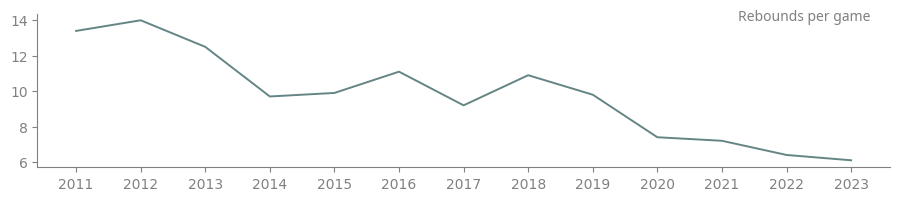

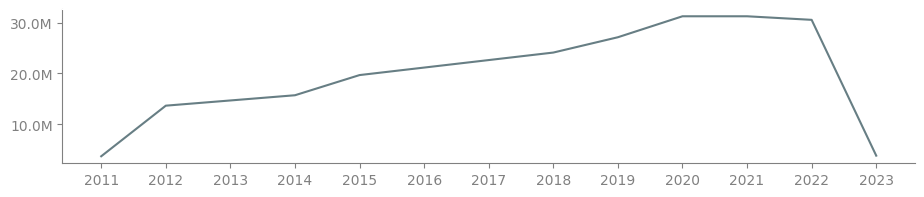

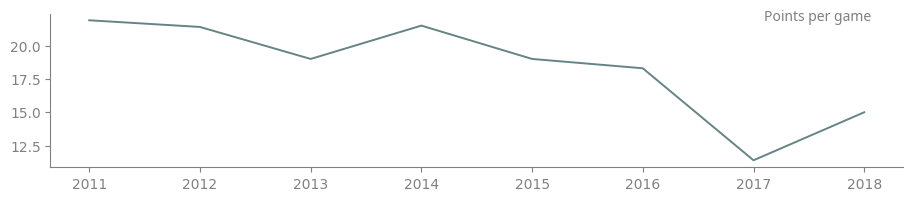

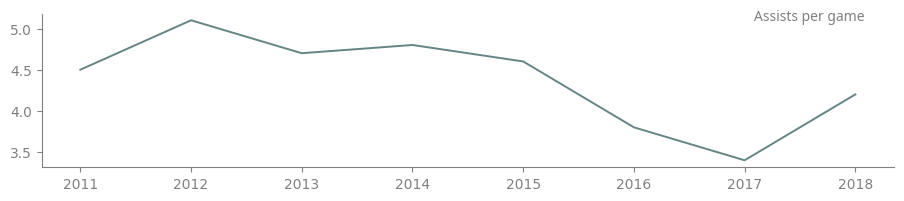

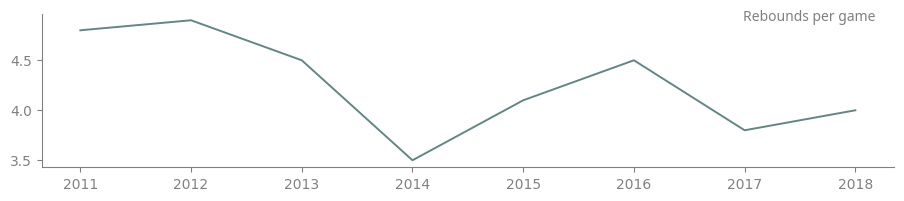

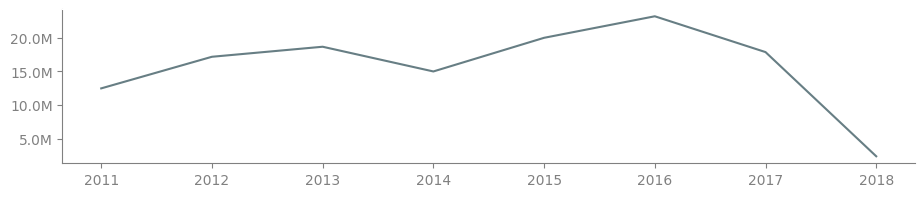

In [ ]:
from download_stats import download_stats
from create_pdf import create_pdf

players = ['Chris Paul', 'Russel Westbrook', 'Devin Booker', 'Kevin Love', 'Dwyane Wade']

for player in players:
    download_stats(player)
    create_pdf(player)